In [91]:
#matplotlib nbagg
%matplotlib inline
from __future__ import division
from data import DatFile, Data2D
import matplotlib.pyplot as plt
import itertools
from scipy import signal, ndimage, optimize
from scipy.optimize import leastsq
import numpy as np

class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [92]:
# These files are taken from Attila's "All peaks" notebook
data_lc = np.load("rawdata.npy").item()
data_abs = np.load("rawdata_dderiv.npy").item()
# The abs z array contains a (now useless) mask, which we discard
data_abs['z'] = data_abs['z'].data

# Convert voltage axis to µV and then to GHz
data_lc['x'] *= 1e6 * 0.4835
data_abs['x'] *= 1e6 * 0.4835

# Chop LC data to take away supercurrent peak and the tail containing ABS peaks
for key, val in data_lc.iteritems():
    a = val[:,6:60] # the indeces at which we chop are chosen by eye
    data_lc[key] = a

# Similarly, chop ABS data
for key, val in data_abs.iteritems():
    a = val[:,35:70] # the indeces at which we chop are chosen by eye
    data_abs[key] = a

# We only need one array for field values
for d in [data_lc, data_abs]:
    y = d['y'][:,0] 
    x = d['x'][0] ## NOTE: THIS MUST BE CORRECTED FOR THE DRIFT!
    d['x'] = x
    d['y'] = y

# Convenience function to plot scans
def plot_datascan(d):
    z = d['z'].T[::-1]
    x = d['x']
    y = d['y']
    
    dx, dy = x[1]-x[0], y[1]-y[0]
    ranges = [y[0]-dy/2, y[-1]+dy/2, x[0]-dx/2, x[-1]+dx/2]
    
    fig, ax = plt.subplots(figsize=(5,5))
    cax = ax.imshow(z, extent = ranges, aspect='auto', interpolation='none', cmap='gist_heat_r')
    cbar = fig.colorbar(cax)
    ax.autoscale(False)

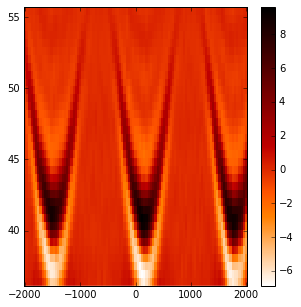

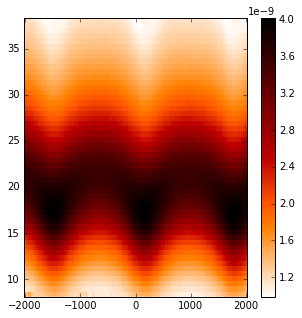

In [93]:
plot_datascan(data_abs)
plot_datascan(data_lc)

## Calibration of phase axis

This procedure assumes a linear relation $\Phi/\Phi_0 = a B + b$.

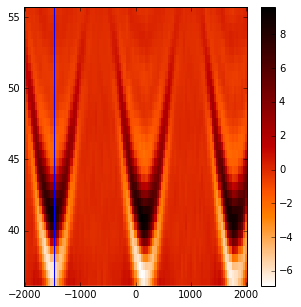

In [94]:
z = data_abs['z']
left = z[2:12] # select a slice for comparison on the left of the dataset
# find most symmetric slice on right part of the dataset
idx = np.argmin([np.linalg.norm(left-np.flipud(z[n:n+10])) for n in xrange(len(z)-10)])
# compute middle point between symmetric slices
x1, x2 = data_abs['y'][11], data_abs['y'][idx]
Bpi = x1 + (x2 - x1) / 2
plot_datascan(data_abs)
plt.axvline(Bpi)
plt.axvline
plt.show()

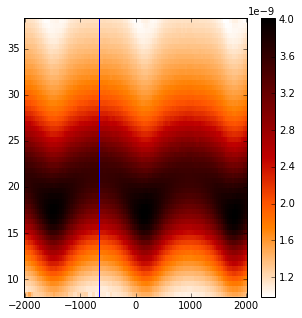

In [95]:
z = data_lc['z']
left = z[20:35] # select a slice for comparison on the left of the dataset
# find most symmetric slice on right part of the dataset
idx = np.argmin([np.linalg.norm(left-np.flipud(z[n:n+15])) for n in xrange(len(z)-15)])
# compute middle point between symmetric slices
x1, x2 = data_lc['y'][34], data_lc['y'][idx]
B0 = x1 + (x2 - x1) / 2
plot_datascan(data_lc)
plt.axvline(B0)
plt.axvline
plt.show()

In [96]:
a, b =  - 2 * (Bpi - B0), B0
data_lc['y'] -= b
data_lc['y'] /= a
data_lc['y'] *= 2*np.pi
data_abs['y'] -= b
data_abs['y'] /= a
data_abs['y'] *= 2*np.pi

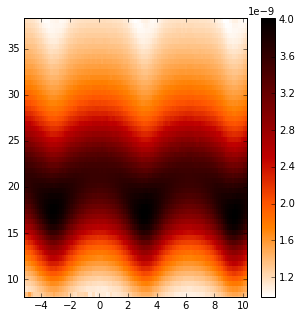

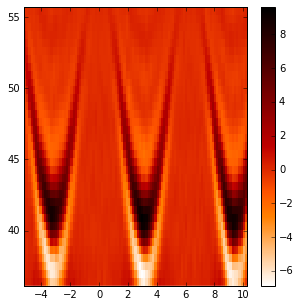

In [97]:
plot_datascan(data_lc)
plot_datascan(data_abs)

In [98]:
# Peak position are simply chosen as the maxima of each data cut for a fixed phase.
lc_pos = np.array([data_lc['x'][np.argmax(d)] for d in data_lc['z']])
abs_pos = np.array([data_abs['x'][np.argmax(d)] for d in data_abs['z']])

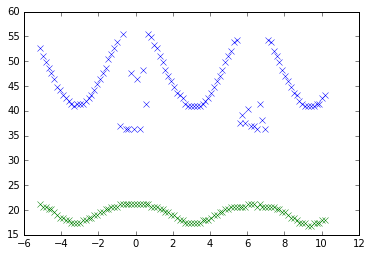

In [99]:
# This leaves some spurious points close to flux = 0 and flux = 1 for the ABS line
plt.plot(data_abs['y'], abs_pos, 'x')
plt.plot(data_lc['y'], lc_pos, 'x')

In [100]:
# These spurious points are removed manually; then we zip phi and V coordinates together
lc_line = zip(data_lc['y'], lc_pos)
abs_line = zip(np.concatenate((data_abs['y'][:28], data_abs['y'][38:69], data_abs['y'][80:])),
               np.concatenate((abs_pos[:28], abs_pos[38:69], abs_pos[80:])))

In [101]:
# A problem with the points is that, due to finite resolution,
# some consecutive points have equal values of voltage. We merge these points
# by taking their average x.
lines = []
for k, group in itertools.groupby(lc_line + abs_line, lambda l: l[1]):
    xs = [g[0] for g in group]
    lines.append((np.mean(xs), k))

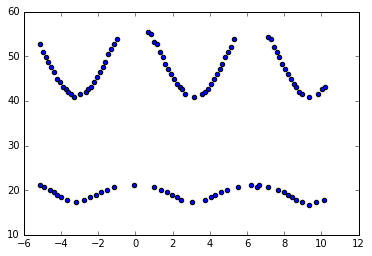

In [102]:
# This is the final dataset
# No error bars (yet..)
phase, frequency = zip(*lines)
plt.scatter(phase, frequency)

## Theoretical model

In [103]:
def potential(phi, p, s='0'):
    r = np.sqrt(1 - p.T) # use reflection amplitude in the formulas, for brevity
    if s == 'z':
        phi = p.flux - phi
        return np.cos(0.5 * r * phi) * np.cos(0.5 * phi) + r * np.sin(0.5 * r * phi) * np.sin(0.5 * phi)
    elif s  == 'y':
        phi = p.flux - phi
        return r * np.cos(0.5 * r * phi) * np.sin(0.5 * phi) - np.sin(0.5 * r * phi) * np.cos(0.5 * phi)
    elif s == '0':
        return (1 - np.cos(phi))
    else:
        raise ValueError('wrong value of s')
        
def n_me(M, dk):
    x = np.pi * dk / M
    return (-1)**dk  / (np.tan(x) * np.sin(x)) / 2

def create_hamiltonian(p, M, sparse=False):
    # offset diagonal term from charging energy
    h0 = p.Ec * (M**2 - 1) / 12 * np.eye(M) + 0j
    
    # cosine part of the potential
    ks = np.arange(-(M-1)/2, (M+1)/2, 1)
    h0 += p.Ej * np.diag(np.array([potential(2 * np.pi * k / M, p, '0') for k in ks])) + 0j
     
    #off diagonal parts of the charging energy
    for dk in range(1, M):
        h0 += p.Ec * n_me(M, dk) * (np.eye(M, k=dk) + np.eye(M, k=-dk)) + 0j
    
    # z, y parts of the potential
    hz = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'z') for k in ks])) + 0j
    hy = p.Ea * np.diag(np.array([potential(2 * np.pi * k / M, p, 'y') for k in ks])) + 0j
    h = np.bmat([[h0 + hz, -1j * hy], [1j * hy, h0 - hz]])
    if sparse:
        return sp.coo_matrix(h)
    else:
        return np.array(h)

def find_optimal_M(p, max_tol = 9e-8, verbose=False):
    M = 3
    tol = 100
    H = create_hamiltonian(p, M, sparse=False)
    ens = np.linalg.eigvalsh(H)
    de = ens[1]-ens[0]
    while tol > max_tol:
        M += 4
        H = create_hamiltonian(p, M, sparse=False)
        ens = np.linalg.eigvalsh(H)
        de_new = ens[1]-ens[0]
        tol = np.abs(de_new - de)
        if verbose:
            print M, de, de_new, tol
        de = de_new
    return M

## Functions for fitting

In [104]:
def rs_abs_model(plist, xs, ys, idx, Ej=None, max_tol=9e-8, sigmas=None):
    """ Returns the list of residuals between the data points
    and the transition energies, given a list of Hamiltonian parameters.

    Parameters:
    -----------
    plist : list of floats
        List of Hamiltonian parameters (excluding flux)
    xs : 1d array
        X values of the data.
    ys : 1d array
        Y values of the data.
    sigmas: 1d array
        Y data errors, if available.
    M : int
        Size of Hamiltonian. Must be odd.
    idx : list
        Index which marks the beginning of data corresponding
        to the ABS transition line. It is used to associate each
        data point to the correct transition energy.

    Return:
    ------
    1d array of weighted residuals.
    """
    p = SimpleNamespace()
    
    p.flux = 0 # Initalize value of flux to compute optimal matriz size
    
    if not Ej:
        p.Ec, p.Ej, p.Ea, p.T = plist
    else:
        p.Ec, p.Ea, p.T = plist
        p.Ej = Ej
    print "Determining matrix size M..."
    M = find_optimal_M(p, max_tol = 9e-8, verbose=True)
    print "Parameter values:"
    print p.Ec, p.Ej, p.Ea, p.T, M
    hams = []
    for x in xs:
        p.flux = x
        hams.append(create_hamiltonian(p, M, sparse=False))
    evals = [np.sort(np.linalg.eigvalsh(h)) for h in hams]
    freqs = [(ev - ev[0])[1:] for ev in evals]
    
    # Chooses which energy level is closest to the ABS line.
    # Note that it may depend on initial parameters.
    n = np.argmin(np.abs(freqs[0] - ys[idx]))
    print "Picking which is the ABS line..."
    print freqs[0][:5], ys[idx], n
    
    frequencies = np.hstack(([f[0] for f in freqs[:idx]],
                             [f[n] for f in freqs[idx:]]))
    weights = (1. / sigmas) if sigmas else 1.
    print "Sum of residues of current iteration:"
    print np.sum(np.abs(frequencies - ys))**2
    print "Going to next iteration...", "\n\n"
    return (frequencies - ys) * weights

In [105]:
def fit_abs_model(lines, idx, p0, Ej=None, max_tol=9e-7):
    """
    Returns the best estimate for the parameters p0 and their
    covariance matrix.

    The obtain the covariance matrix, the jacobian around the
    solution returned by leastsq is multiplied by the residual variance

    s = sum(rs) / (n-m)

    where n is the number of data points and m the number of fitting
    parameters. This is the same as what is done in scipy.optimize.curve_fit.
    
    Parameters:
    -----------
    lines : list
        List of points to be fitted, one list for every
        different transition.
    idx: int
        Index which marks the beginning of data corresponding
        to the ABS transition line.
    p0 : list
        Initial guess for the fitting parameters.
    Ej : float
        Josephson energy of the conventional junction.
        If Ej=None, Ej is passed via p0 and included as fitting parameter.
        Otherwise, it is kept as a fixed parameter.
    """
    fit_result = {'initial_guess' : p0}
    xs, ys= np.asarray(zip(*lines))
    #lengths = [len(l) for l in lines]
    #idxs = [sum(lengths[:n]) for n in np.arange(1, 7)]
    (popt, pcov, infodict, errmsg, ier) = leastsq(rs_abs_model, x0=p0,
                                                  args=(xs, ys, idx, Ej, max_tol), full_output=1)
    print popt
    print pcov
    print infodict
    print errmsg
    print ier
    chi_squared = (np.asarray(rs_abs_model(popt, xs, ys, idx, Ej, max_tol))**2).sum()
    chi_squared /= (len(xs) - len(popt))
    pcov = pcov * chi_squared
    std_devs = np.sqrt(np.diag(pcov))
    fit_result['popt'] = popt
    fit_result['chi_squared'] = chi_squared
    fit_result['infodict'] = infodict
    fit_result['pcov'] = pcov
    fit_result['std_devs'] = std_devs
    fit_result['errmsg'] = errmsg
    fit_result['ier'] = ier
    return fit_result

def plot_fit_results(res, lines, Ej=None):
    p =  SimpleNamespace()
    if not Ej:
        p.Ec, p.Ej, p.Ea, p.T = res['popt']
    else:
        p.Ec, p.Ea, p.T = res['popt']
        p.Ej = Ej
    
    p.flux = 0
    p.M = find_optimal_M(p, verbose=False)
    
    fluxes = np.linspace(-2*np.pi, 4*np.pi, 200)
    hams = []
    for flux in fluxes:
        p.flux = flux
        hams.append(create_hamiltonian(p, p.M, sparse=False))
    evals = [np.sort(np.linalg.eigvalsh(h)) for h in hams]
    freqs = np.array([(ev - ev[0])[1:] for ev in evals])
    p.flux = 0.
    _, evec = np.linalg.eigh(create_hamiltonian(p, p.M))
    
    ## Plot of the fit
    fig, ax = plt.subplots(figsize=(8,8))
    for (n, f) in enumerate(freqs.T[:5]):
        print
        ax.plot(fluxes, f, c='k')
    phase, frequency = zip(*lines)
    ax.scatter(phase, frequency)
    ax.set_xlim((-2*np.pi, 4*np.pi))
    ax.set_title(r'$E_C=%.4s, E_J=%.4s, E_A=%.4s, T=%.4s$' % (p.Ec, p.Ej, p.Ea, p.T))
    fig.show()
    
    ## Plot of the wavefunctions at zero flux
    p.flux = 0.
    _, evec = np.linalg.eigh(create_hamiltonian(p, p.M))
    wavefunctions = evec.T
    for (n, wf) in enumerate(wavefunctions[:5]):
        L = len(wf)
        fig, ax = plt.subplots(figsize=(5,2))
        ax.plot(np.abs(wf)**2, 'k.')
        ax.set_xlim(0, L)
        plt.axvline(L/2, c='k')
        ax.set_ylabel(r'$|\Psi(\phi)|^2$')
        ax.set_xticks([L/8, L/4, 3*L/8, 5*L/8, 3*L/4, 7*L/8])
        ax.set_xticklabels([r'$-\pi/2$', r'$0$', r'$-\pi/2$', r'$-\pi/2$', r'$0$', r'$-\pi/2$'])
        ax.set_yticks([])
        ax.set_title(r'Eigenstate \# %s' % n)
        fig.show()

## Estimating parameters for the 100 nm device

From the measured $I_J^c \approx 159$ nA, I obtain $E_J/h \approx 78.9$ GHz.

From the measured plasma frequency at pinch-off $\omega_\textrm{pinch-off}$, I obtain $E_c \approx \omega^2_\textrm{pinch-off}/2E_J \approx 3.66$ GHz.

For $E_A$ and transmission $T$, I take similar values as for the $30$ nm device: $E_A\approx 33$ GHz, $T\approx 0.5$.

This gives the set of initial values for the fitting.

## Fit with four free parameters

In [ ]:
p0 = [3, 79, 33, 0.75]
fitres = fit_abs_model(lines, 41, p0)

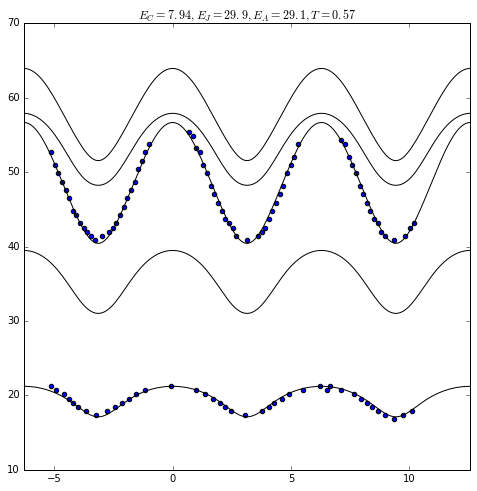

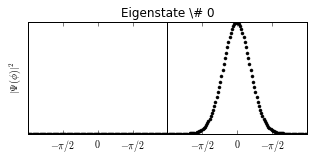

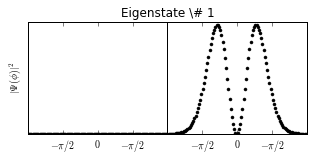

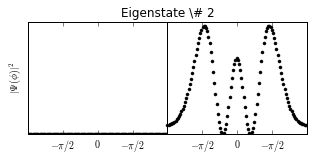

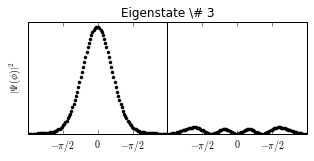

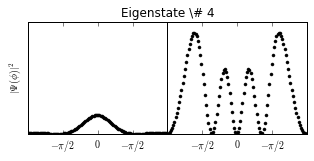

In [107]:
plot_fit_results(fitres, lines)

## Fit with three free parameters

In [ ]:
p0 = [3, 33, 0.9]
fitres_fixed_ej = fit_abs_model(lines, 41, p0, Ej=78.9)

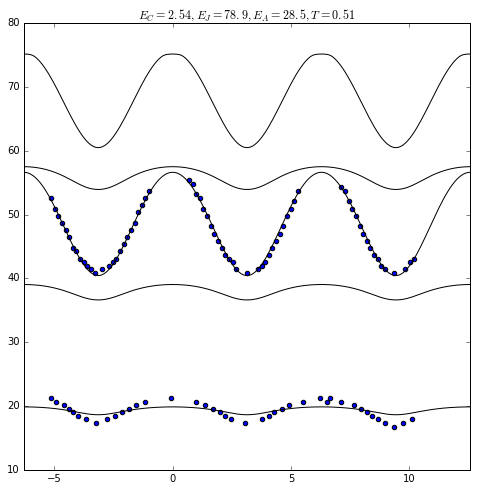

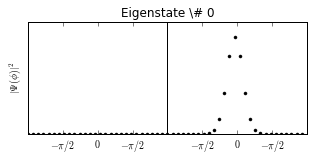

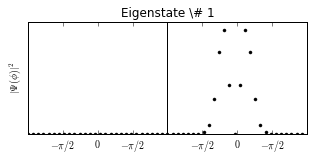

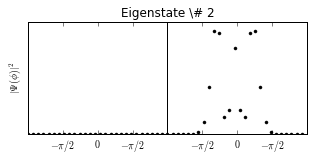

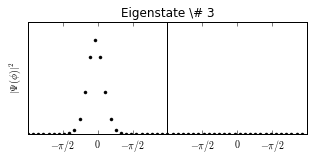

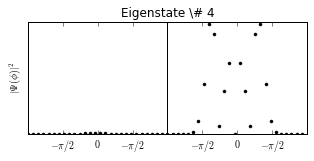

In [109]:
plot_fit_results(fitres_fixed_ej, lines, Ej=78.9)

## Cruft, maybe useful later

In [ ]:
## Attempt at finding error bar
def interpolate_sign_change(x, y):
    # See http://stackoverflow.com/questions/2652368/how-to-detect-a-sign-change-for-elements-in-a-numpy-array
    ysign = np.sign(y)
    signchange = ((np.roll(ysign, 1) - ysign) != 0).astype(int)
    signchange[0]=0
    yp = y[np.where(signchange == 1)][:2]
    ym = y[np.where(np.roll(signchange,-1) == 1)][:2]
    xp = x[np.where(signchange == 1)][:2]
    xm = x[np.where(np.roll(signchange,-1) == 1)][:2]
    
    ms = (yp - ym) / (xp - xm)
    bs = yp - ms * xp
    errs = - bs / ms
    return list(errs)
#abs_errs = np.array([np.where(np.abs(d) < 1e-3)[0][:2] for d in data_abs['z']])

In [ ]:
bars = [interpolate_sign_change(data_abs['x'], d) for d in data_abs['z']]

In [ ]:
bars = np.array([b or [0.,0.] for b in bars]).T

In [ ]:
bars[0] = abs_pos - bars[0]
bars[1] = bars[1] - abs_pos

In [ ]:
# Clearly still some adjustment needed...
plt.errorbar(data_abs['y'], abs_pos, yerr=bars)